In [1]:
import random
import datetime
from typing import List, Dict
import timeit
import functools
from collections import Counter
import sys

import numpy as np
import pandas as pd
import pandasql as ps
from tqdm import tqdm
import matplotlib.pyplot as plt

global enhanced_forecasts
global enhanced_rates

In [2]:
file_name = "gorilla_test_data.xlsx"
meters = pd.read_excel(file_name, sheet_name=0)
forecasts = pd.read_excel(file_name, sheet_name=1,)
rates = pd.read_excel(file_name, sheet_name=2)

In [3]:
def extend_meters(meters: pd.DataFrame, forecasts: pd.DataFrame) -> pd.DataFrame:
    return pd.merge(meters.copy(), forecasts, on="meter_id")

In [4]:
extended_meters = extend_meters(meters, forecasts)

In [5]:
extended_meters

,meter_id,aq_kwh,exit_zone,date,kwh
0,14676236,28978,EA1,2020-06-01,22.070768
1,14676236,28978,EA1,2020-06-02,19.170720
2,14676236,28978,EA1,2020-06-03,23.555111
3,14676236,28978,EA1,2020-06-04,18.220712
4,14676236,28978,EA1,2020-06-05,14.196134
...,...,...,...,...,...
3407,88357331,484399,SE2,2022-09-27,441.014725
3408,88357331,484399,SE2,2022-09-28,441.512055
3409,88357331,484399,SE2,2022-09-29,437.240657
3410,88357331,484399,SE2,2022-09-30,517.608354


In [6]:
rates

,date,exit_zone,aq_min_kwh,aq_max_kwh,rate_p_per_kwh
0,2020-04-01,EA1,0,73200.0,0.2652
1,2020-04-01,EA1,73200,732000.0,0.1980
2,2020-04-01,EA1,732000,NaN,0.2875
3,2020-04-01,EA2,0,73200.0,0.2970
4,2020-04-01,EA2,73200,732000.0,0.1524
...,...,...,...,...,...
1135,2024-10-01,WM2,73200,732000.0,0.4537
1136,2024-10-01,WM2,732000,NaN,0.7534
1137,2024-10-01,WM3,0,73200.0,0.7263
1138,2024-10-01,WM3,73200,732000.0,0.6109


In [7]:
def rate_table_add_end_date(rates: pd.DataFrame) -> pd.DataFrame:
    return_rates = rates.copy()
    start_dates = list(rates.date.unique())
    end_dates = start_dates[1:] + [None]
    return_rates.insert(loc=1, column="end_date", value=rates.date + pd.tseries.offsets.DateOffset(months=6))
    return_rates = return_rates.fillna(1e20)
    return return_rates

In [8]:
extended_rates = rate_table_add_end_date(rates)

In [9]:
extended_rates

,date,end_date,exit_zone,aq_min_kwh,aq_max_kwh,rate_p_per_kwh
0,2020-04-01,2020-10-01,EA1,0,7.320000e+04,0.2652
1,2020-04-01,2020-10-01,EA1,73200,7.320000e+05,0.1980
2,2020-04-01,2020-10-01,EA1,732000,1.000000e+20,0.2875
3,2020-04-01,2020-10-01,EA2,0,7.320000e+04,0.2970
4,2020-04-01,2020-10-01,EA2,73200,7.320000e+05,0.1524
...,...,...,...,...,...,...
1135,2024-10-01,2025-04-01,WM2,73200,7.320000e+05,0.4537
1136,2024-10-01,2025-04-01,WM2,732000,1.000000e+20,0.7534
1137,2024-10-01,2025-04-01,WM3,0,7.320000e+04,0.7263
1138,2024-10-01,2025-04-01,WM3,73200,7.320000e+05,0.6109


In [10]:
def merge_forecasts_rates(extended_meters, extended_rates):
    merge_code = """
    select extended_meters.meter_id,extended_meters.aq_kwh,extended_meters.exit_zone,
    extended_meters.date, extended_meters.kwh, extended_rates.rate_p_per_kwh, extended_rates.date
    from extended_meters
    inner join extended_rates on extended_meters.exit_zone=extended_rates.exit_zone
    where extended_meters.date >= extended_rates.date and extended_meters.date < extended_rates.end_date 
    and extended_meters.aq_kwh >= extended_rates.aq_min_kwh and extended_meters.aq_kwh < extended_rates.aq_max_kwh
    """
    newdf = ps.sqldf(merge_code, locals())
    return newdf

In [11]:
newdf = merge_forecasts_rates(extended_meters, extended_rates)

In [12]:
newdf

,meter_id,aq_kwh,exit_zone,date,kwh,rate_p_per_kwh,date
0,14676236,28978,EA1,2020-06-01 00:00:00.000000,22.070768,0.2652,2020-04-01 00:00:00.000000
1,14676236,28978,EA1,2020-06-02 00:00:00.000000,19.170720,0.2652,2020-04-01 00:00:00.000000
2,14676236,28978,EA1,2020-06-03 00:00:00.000000,23.555111,0.2652,2020-04-01 00:00:00.000000
3,14676236,28978,EA1,2020-06-04 00:00:00.000000,18.220712,0.2652,2020-04-01 00:00:00.000000
4,14676236,28978,EA1,2020-06-05 00:00:00.000000,14.196134,0.2652,2020-04-01 00:00:00.000000
...,...,...,...,...,...,...,...
3407,88357331,484399,SE2,2022-09-27 00:00:00.000000,441.014725,0.3647,2022-04-01 00:00:00.000000
3408,88357331,484399,SE2,2022-09-28 00:00:00.000000,441.512055,0.3647,2022-04-01 00:00:00.000000
3409,88357331,484399,SE2,2022-09-29 00:00:00.000000,437.240657,0.3647,2022-04-01 00:00:00.000000
3410,88357331,484399,SE2,2022-09-30 00:00:00.000000,517.608354,0.3647,2022-04-01 00:00:00.000000


In [13]:
def generate_cost_table(newdf: pd.DataFrame) -> pd.DataFrame:
    newdf["costs_p"] = newdf["kwh"] * newdf["rate_p_per_kwh"]
    result = newdf[["meter_id","kwh", "costs_p"]].groupby("meter_id").sum()
    result["costs_pounds"] = result["costs_p"] / 100
    result = result.drop(columns="costs_p").round(2)
    return result

In [14]:
result = generate_cost_table(newdf)
result

,kwh,costs_pounds
meter_id,,
14676236,28978.0,100.15
34509937,78324.0,275.49
50264822,265667.0,731.24
88357331,484399.0,1433.16


## Generator Functions

In [15]:
def generate_random_meters(size: int):
    list_of_data: List[Dict] = []
    random_meters = random.sample(range(10000000, 100000000), size)
    for integer in range(size):
        random_dict = {"meter_id": random_meters[integer],
                      "aq_kwh": int(10**random.uniform(4.0, 7.0)),
                      "exit_zone": random.choice(rates["exit_zone"].unique())}
        list_of_data.append(random_dict)
    return pd.DataFrame(list_of_data)

In [16]:
random_meters = generate_random_meters(5)

In [17]:
random_meters

,meter_id,aq_kwh,exit_zone
0,19914440,1990179,EA1
1,49954750,12866,LW
2,63886898,1957573,SW1
3,69368325,11401,SW3
4,10417498,272716,LW


In [18]:
def _generate_one_meter_consumption_data(meter: int, start_date: datetime.date, duration: int):
    dates = pd.date_range(start_date, periods=duration)
    random_multiplier = random.random()
    random_samples = 1000 * random_multiplier * np.random.random_sample((duration,))
    d = {"meter_id": meter, "date": dates, "kwh": random_samples}
    return pd.DataFrame(data=d)

def generate_mock_consumption_data(meter_list: List[int], start_date: datetime.date, duration: int):
    assert duration > 1
    all_dfs: List[pd.DataFrame] = []
    all_dfs = [_generate_one_meter_consumption_data(meter_id, start_date, duration) for meter_id in meter_list]
    return pd.concat(all_dfs).reset_index(drop=True)

In [19]:
generate_mock_consumption_data(random_meters["meter_id"].tolist(), start_date=datetime.date(2021, 1, 1),
                              duration=100)

,meter_id,date,kwh
0,19914440,2021-01-01,403.140887
1,19914440,2021-01-02,3.472464
2,19914440,2021-01-03,636.338491
3,19914440,2021-01-04,578.508650
4,19914440,2021-01-05,256.752675
...,...,...,...
495,10417498,2021-04-06,380.064933
496,10417498,2021-04-07,203.085414
497,10417498,2021-04-08,22.493867
498,10417498,2021-04-09,126.822141


In [20]:
def generate_transportation_cost_table(meters: pd.DataFrame, forecasts: pd.DataFrame) -> pd.DataFrame:
    extended_meters = extend_meters(meters, forecasts)
    newdf = merge_forecasts_rates(extended_meters, extended_rates)
    result = generate_cost_table(newdf)
    return result

In [23]:
def benchmark_cost_table_generator(meter_list_length: int, forecast_length: int) -> float:
    meters = generate_random_meters(meter_list_length)
    forecasts = generate_mock_consumption_data(
        meters["meter_id"].tolist(), start_date=datetime.date(2021, 1, 1), duration=forecast_length)
    test_func = functools.partial(generate_transportation_cost_table, meters, forecasts)
    return timeit.timeit(test_func, number=1)

In [24]:
# try this out
benchmark_cost_table_generator(10, 10)

0.03377622200002861

In [25]:
# How does the function scale for larger sets of data?
timings: List[Dict] = []
for forecast_len in tqdm(range(300, 2700, 300)):
    num_sec = benchmark_cost_table_generator(1000, forecast_len)
    timings.append({"forecast_length": forecast_len, "sec": num_sec})
all_timings = pd.DataFrame(timings)

100%|█████████████████████████████████████████████| 8/8 [03:16<00:00, 24.54s/it]


<AxesSubplot: xlabel='forecast_length'>

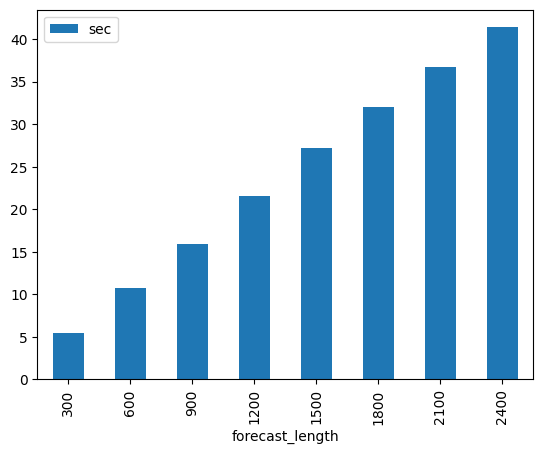

In [26]:
all_timings.plot(x="forecast_length", y="sec", kind="bar")

# The function scales linearly. It is an O(n) function.

# The cost calculation could be improved looking at different technologies and how they scale.
# Maybe the SQL join can be improved in some way, for example there could be some preprocessing done on the date
# So that just one comparison needs to run instead of two. This would stil improve the processing speed.
# The extended metres dataframe for this would have an extra column: processed_date
# Also, the extended metres dataframe could be preprocessed for the annual quantity (column quantity_range), 
# so that also one comparison needs to be done in the SQL join instead of two. 
# This will also make the inner join a faster function.
# When doing this preprocessing, a join can be done in pandas instead of using the external pandasql library.
# Possible this will also result in a faster function.
# Possibly, but not sure, working with numeric dates instead of datetimes would still increase the speed a bit.